# Feature Engineering and Creation

#### v 2.0

In this feature engineering pipeline, the focus will be to try to improve the result for XGBoost model.

## Imports and Setup

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

sns.set(style='darkgrid', palette='pastel')
pd.options.display.max_columns = None

In [2]:
data = pd.read_csv('../data/processed/0_cleaned.csv')
data_backup = data.copy()

label = data[['Value', 'Wage']]
data.drop(columns=['Value', 'Wage'], inplace=True)

In [3]:
data.head(5)

,Age,Nationality,Overall,Potential,Club,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Jersey Number,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31.0,Argentina,94.0,94.0,FC Barcelona,2202.0,Left,5.0,4.0,4.0,Medium/ Medium,Messi,RF,10.0,170.18,159.0,88.0,88.0,88.0,92.0,93.0,93.0,93.0,92.0,93.0,93.0,93.0,91.0,84.0,84.0,84.0,91.0,64.0,61.0,61.0,61.0,64.0,59.0,47.0,47.0,47.0,59.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33.0,Portugal,94.0,94.0,Juventus,2228.0,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,ST,7.0,187.96,183.0,91.0,91.0,91.0,89.0,90.0,90.0,90.0,89.0,88.0,88.0,88.0,88.0,81.0,81.0,81.0,88.0,65.0,61.0,61.0,61.0,65.0,61.0,53.0,53.0,53.0,61.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26.0,Brazil,92.0,93.0,Paris Saint-Germain,2143.0,Right,5.0,5.0,5.0,High/ Medium,Neymar,LW,10.0,175.26,150.0,84.0,84.0,84.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,89.0,88.0,81.0,81.0,81.0,88.0,65.0,60.0,60.0,60.0,65.0,60.0,47.0,47.0,47.0,60.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27.0,Spain,91.0,93.0,Manchester United,1471.0,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,1.0,193.04,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27.0,Belgium,91.0,92.0,Manchester City,2281.0,Right,4.0,5.0,4.0,High/ High,Normal,RCM,7.0,180.34,154.0,82.0,82.0,82.0,87.0,87.0,87.0,87.0,87.0,88.0,88.0,88.0,88.0,87.0,87.0,87.0,88.0,77.0,77.0,77.0,77.0,77.0,73.0,66.0,66.0,66.0,73.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [4]:
label.isnull().sum()

Value    0
Wage     0
dtype: int64


## Transform Categorical Features

In [5]:
categorical_columns = np.asarray([not np.issubdtype(data[col].dtype, np.number) for col in data.columns], dtype=np.bool)
cat_col_names = [col for col in data.columns if not np.issubdtype(data[col].dtype, np.number)]
num_col_names = [col for col in data.columns if np.issubdtype(data[col].dtype, np.number)]

categorical_data = data.iloc[:, categorical_columns]
non_categorical = data.iloc[:, ~categorical_columns]
categorical_data.reset_index(inplace=True, drop=True)
non_categorical.reset_index(inplace=True, drop=True)

### Transform Using OneHotEncoding

In [6]:
cardinality_threshold = 10
cols_to_reduce_dim = []
for c in cat_col_names:
    levels = categorical_data[c].drop_duplicates().shape[0]
    if levels > cardinality_threshold:
        cols_to_reduce_dim.append(c)      

df_reduce = categorical_data[cols_to_reduce_dim]
df_reduce = pd.get_dummies(df_reduce)

svd = PCA(n_components=0.85)
df_reduce = svd.fit_transform(df_reduce)

column_names = []
for col in range(df_reduce.shape[1]):
    column_names.append('reduced_col_{}'.format(col))
df_reduce = pd.DataFrame(df_reduce, columns=column_names)

df_dummies = categorical_data.drop(cols_to_reduce_dim, axis=1)
df_dummies = pd.get_dummies(df_dummies)

df_dummies = df_dummies.join(df_reduce)
df_dummies = df_dummies.join(non_categorical)

### Transform Using Ordinal Encoding

In [7]:
encoder = OrdinalEncoder()
encoder.fit(categorical_data)
column_names = categorical_data.columns
categorical_data = encoder.transform(categorical_data)
df_ordinal = pd.DataFrame(categorical_data, columns=column_names)
del categorical_data
df_ordinal = non_categorical.join(df_ordinal)
del non_categorical

## Data Boxplot

In [8]:
def get_boxpolt_info(data, size=[10,5], axis_rotation=0):
    plt.rcParams['figure.figsize'] = size
    ax = sns.boxplot(data=data)
    plt.title('Numerical Features Distribution')
    if axis_rotation:
        plt.xticks(rotation=axis_rotation)
    plt.show()

In [ ]:
get_boxpolt_info(df_ordinal[num_col_names], size=(20, 5), axis_rotation=90)

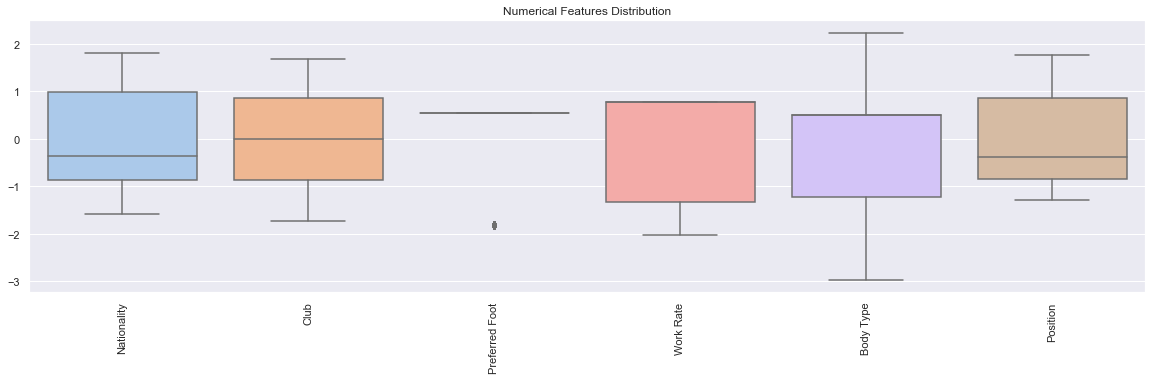

In [41]:
get_boxpolt_info(df_ordinal[cat_col_names], size=(20, 5), axis_rotation=90)

In [12]:
df_ordinal.reset_index(inplace=True, drop=True)
df_dummies.reset_index(inplace=True, drop=True)

In [13]:
label.reset_index(inplace=True, drop=True)

In [15]:
df_ordinal_final = df_ordinal.join(label)
df_ordinal_final.to_csv('../data/processed/2_1_processed_ordinal_encoding_xgboost.csv', index_label=False)

In [16]:
df_dummies_final = df_dummies.join(label)
df_dummies_final.to_csv('../data/processed/2_1_processed_onehot_encoding_xgboost.csv', index_label=False)